In [48]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt

# Load data
print('Loading data...')
crime_df = pd.read_csv('data/Crimes_-_2001_to_2021.csv')
print('Loaded the data!')

# Cleaning dataframe
crime_df.drop(columns=['Case Number','Block','IUCR','Primary Type', # IUCR of Primary Type ?
                        'Description','Location Description','Arrest', # Location Description voor LSTM ?
                        'Domestic','Beat','District','Ward','Community Area', # Community Are voor visualisatie
                        'FBI Code','Updated On','Location'], inplace=True)
crime_df = crime_df.rename(columns={'X Coordinate':'x', 'Y Coordinate':'y'})
crime_df.dropna(inplace=True)

# Extract last month of data
print('Converting to datetime column')
month_crime_df = crime_df.loc[crime_df['Year'] == 2021]
month_crime_df['Date'] = pd.to_datetime(month_crime_df['Date'])
month_crime_df = month_crime_df.loc[crime_df['Date'] > '11/31/2021']
print('Done.')

Loading data...
Loaded the data!
Converting to datetime column


C:\Users\lcdew\AppData\Local\Temp\ipykernel_6296\1704907568.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_crime_df['Date'] = pd.to_datetime(month_crime_df['Date'])


Done.


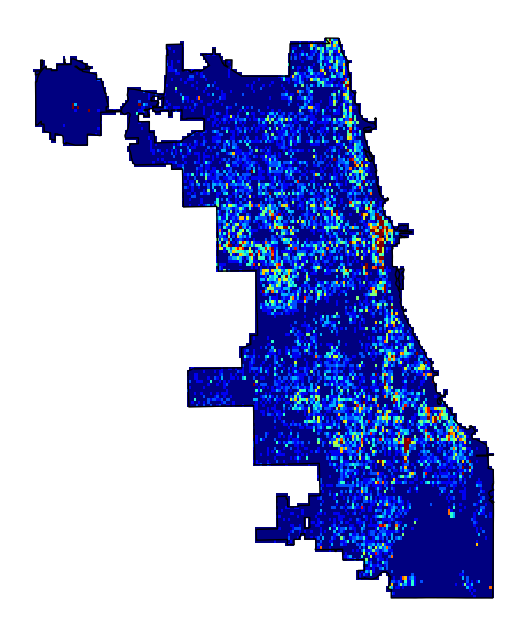

In [49]:
path = 'data/shapefile/geo_export.shp'
chicago = gpd.read_file(path)
chicago = chicago.dissolve()

crs = "EPSG:4326"
gdf = gpd.GeoDataFrame(month_crime_df, geometry=gpd.points_from_xy(month_crime_df.Longitude, month_crime_df.Latitude), crs=crs)

xmin, ymin, xmax, ymax = chicago.total_bounds
n_cells=200
cell_size = (xmax-xmin)/n_cells
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        x1 = x0-cell_size
        y1 = y0+cell_size
        box = shapely.geometry.box(x0, y0, x1, y1)
        if chicago.intersection(box).any():
            grid_cells.append(box)
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

merged = gpd.sjoin(gdf, cell, how='left', predicate='within')
merged['n_crimes'] = 0
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell['n_crimes'] = 0
cell.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values

ax = cell.plot(column='n_crimes', figsize=(12, 8), vmax=10, cmap='jet', edgecolor=None)
chicago.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

plt.show()